<a href="https://colab.research.google.com/github/FilipKatulski/natural-language-processing/blob/dev-task3/3-levenshtein/nlp3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Levenshtein distance and spelling corrections

In [1]:
!pip install spacy
!python -m spacy download pl_core_news_sm
!pip install morfeusz2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 29.1 MB/s 


In [2]:
!curl https://apohllo.pl/text/ustawy.tar.gz --output ustawy.tar.gz
!ls -la
!mkdir ustawy
!tar -xzf ustawy.tar.gz -C ustawy 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8662k  100 8662k    0     0  6864k      0  0:00:01  0:00:01 --:--:-- 6864k
total 8680
drwxr-xr-x 1 root root    4096 Nov 17 19:28 .
drwxr-xr-x 1 root root    4096 Nov 17 19:27 ..
drwxr-xr-x 4 root root    4096 Nov 16 14:34 .config
drwxr-xr-x 1 root root    4096 Nov 16 14:35 sample_data
-rw-r--r-- 1 root root 8870313 Nov 17 19:28 ustawy.tar.gz


In [17]:
import spacy
import os
import pandas as pd
import re
import functools

from typing import Any, Callable
from random import sample
from spacy.lang.pl import Polish
from morfeusz2 import Morfeusz
from collections import Counter


In [7]:
path_to_files = "ustawy"

def read_normalized_documents():  # returns dict[str, str]
    file_names = os.listdir(path_to_files)
    return {
        name: _normalize_document(_read_document(name, path_to_files))
        for name in file_names
        if name.endswith(".txt")
    }

def _read_document(name: str, path: str):
    with open(os.path.join(path, name), 'r') as f:
        return f.read()


def _normalize_document(document: str):
    return re.sub(r"\s+", " ", document).lower()

3. Use SpaCy tokenizer API to tokenize the text from the cleaned law corpus.

In [12]:
nlp = spacy.load("pl_core_news_sm")  # had to be downloaded separately
tokenizer = nlp.tokenizer
documents = read_normalized_documents()

3. Use SpaCy tokenizer API to tokenize the text from the cleaned law corpus

In [15]:
tokenized_documents = {name: [t.text for t in tokenizer(text)] for name, text in documents.items()}

for name, tokens in sample(list(tokenized_documents.items()), 10):
    print(f"{name:<15}: {sample(tokens, 10)}")

2000_273.txt   : ['do', 'niezbędne', 'art', 'składniki', 'września', 'turystyki', '3', '.', 'turystycznej', '14']
2001_1150.txt  : ['3', 'obliczone', '117', 'korzystającemu', '.', 'których', 'się', 'środków', 'a', 'najmniej']
1997_685.txt   : ['prawo', 'fundusz', '%', 'ogłoszenia', 'zmianie', '90', '.', '5', '685', ')']
2003_452.txt   : ['23', 'bez', 'sejmu', '.', 'zmianie', 'ujawniających', ')', 'ustawy', 'r', 'dz']
2000_820.txt   : ['-', '776', '4b', 'r', '.', '69', '1', 'pożyczek', 'stanowiącej', 'i']
1997_643.txt   : ['grudnia', 'r', 'telewizji', '4', '.', ',', 'w', 'ust', 'r', 'nr']
1996_493.txt   : ['1', '60', 'przekształceń', 'tych', '.', 'tryb', 'w', '.', '.', 'i']
1997_97.txt    : ['.', 'wolności', 'ustawa', '.', 'prezydenta', 'r', 'dotyczącego', 'człowieka', 'r', 'stycznia']
2001_476.txt   : ['3', 'stałego', 'której', 'osoby', 'urodzenia', 'po', ',', 'mowa', '31b', ',']
1995_141.txt   : ['do', 'samorządzie', 'ustawa', '.', 'od', '1996', 'r', '24h', 'nr', 'nr']


4. Compute frequency list for each of the processed files

In [18]:
freq_list = {name: Counter(tokens) for name, tokens in tokenized_documents.items()}

for name, cnt in sample(list(freq_list.items()), 10):
    print(f"{name:<15}: {cnt.most_common(5)}")

2000_269.txt   : [('.', 179), (',', 171), ('w', 68), ('nr', 52), ('poz', 52)]
1996_102.txt   : [('.', 58), (',', 49), ('i', 37), ('w', 24), ('z', 19)]
1997_939.txt   : [('.', 17), ('z', 5), ('r', 4), ('art', 4), ('1997', 3)]
2004_2598.txt  : [('.', 58), ('_', 31), (',', 29), ('w', 19), ('1', 15)]
1997_569.txt   : [('.', 398), (',', 367), ('w', 262), ('"', 198), (')', 141)]
1997_673.txt   : [(',', 262), ('.', 234), ('w', 135), ('do', 68), ('i', 59)]
2003_2049.txt  : [('w', 13), ('.', 8), ('rzeczypospolitej', 5), ('polskiej', 5), ('bezpieczeństwa', 4)]
2000_636.txt   : [('.', 10), ('energetycznej', 6), ('karty', 4), ('r', 3), ('dnia', 3)]
2000_136.txt   : [('.', 2580), (',', 1770), ('w', 1349), ('"', 1000), (')', 742)]
1996_703.txt   : [('.', 623), (',', 415), ('w', 326), ('art', 176), ('"', 157)]


5. Aggregate the result to obtain one global frequency list.

In [19]:
tokens_global = [t for tokens in tokenized_documents.values() for t in tokens]
glob_freq_list = Counter(tokens_global)

glob_freq_list.most_common(10)

[('.', 431293),
 (',', 341126),
 ('w', 201200),
 (')', 100194),
 ('i', 90006),
 ('art', 83804),
 ('z', 82438),
 ('1', 72952),
 ('o', 64776),
 ('-', 61714)]

6. Reject all entries that are shorter than 2 characters or contain non-letter characters (make sure to include Polish diacritics).


In [20]:
def is_ok(s):
    return (len(s) > 1) and (re.search(r"[\W\d_]", s) is None)

clean_glob_freq_list = {t: cnt for t, cnt in glob_freq_list.items() if is_ok(t)}
sample(list(clean_glob_freq_list.items()), 10)

[('halon', 3),
 ('pieszy', 3),
 ('brat', 5),
 ('newralgicznych', 2),
 ('kadencje', 24),
 ('puszki', 1),
 ('spółdzielczej', 72),
 ('odwołać', 115),
 ('tajemnicach', 2),
 ('honorowym', 4)]

7. Make a plot in a logarithmic scale (for X and Y).

In [22]:
df = pd.DataFrame({
    'token': list(clean_glob_freq_list.keys()),
    'count': list(clean_glob_freq_list.values())
})
df = df.sort_values(['count', 'token'], ascending=False)
df = df.reset_index(drop=True)
df['rank'] = list(range(1, len(df) + 1))
df.head()



,token,count,rank
0,art,83804,1
1,do,60732,2
2,ust,53636,3
3,na,50643,4
4,się,45886,5


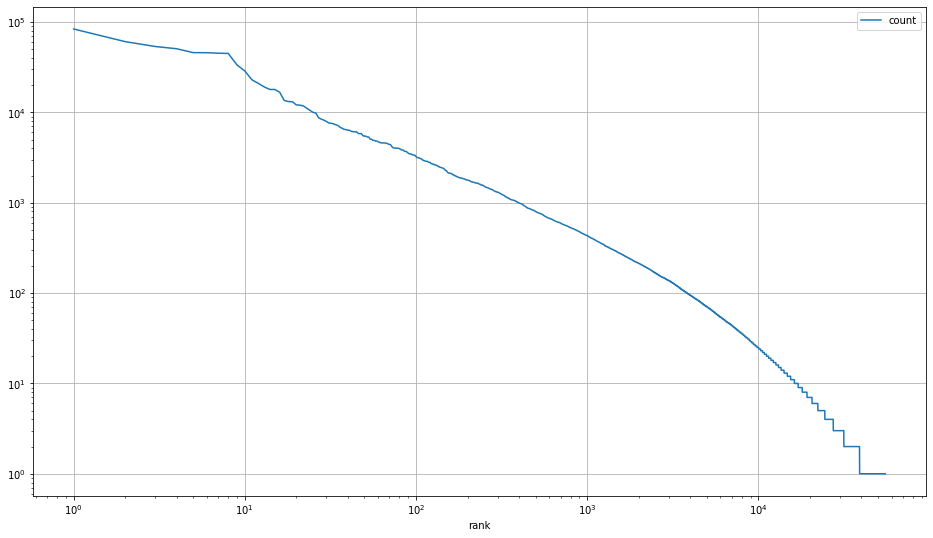

In [33]:
df.plot(x='rank', y='count', logx=True, logy=True, figsize=(16,9), grid=True)


8. Installed Morfeusz and used it to find all words that do not appear in that dictionary.


In [24]:
morf = Morfeusz(aggl="isolated")

def is_in_morfeusz(s):
    return morf.analyse(s)[0][2][2] != "ign"


9. Find 30 words with the highest ranks that do not belong to the dictionary.

In [25]:
df_unknown = df[~df['token'].apply(is_in_morfeusz)]
df_unknown.iloc[:30]


,token,count,rank
371,późn,1065,372
1435,gmo,298,1436
1975,sww,216,1976
2174,skw,196,2175
2501,ex,167,2502
2571,ike,162,2572
3350,remediacji,120,3351
3733,ure,103,3734
3907,uke,97,3908
3993,kn,95,3994


10. Find 30 random words (i.e. shuffle the words) with 5 occurrences that do not belong to the dictionary.

In [26]:
df_unknown[df_unknown['count'] == 5].sample(30)

,token,count,rank
22399,zawart,5,22400
23089,rialnego,5,23090
24057,instrumen,5,24058
24037,jed,5,24038
22916,swine,5,22917
22698,wapnio,5,22699
23120,regazyfikacyjnego,5,23121
23161,próbobiorców,5,23162
22864,teryto,5,22865
24297,cznika,5,24298


11. Use Levenshtein distance and the frequency list, to determine the most probable correction of the words from lists defined in points 8 and 9 (Note: You don't have to apply the distance directly. Any method that is more efficient than scanning the dictionary will be appreciated.)

In [27]:
known_words = {w: cnt for w, cnt in clean_glob_freq_list.items() if is_in_morfeusz(w)}
words_total_number = sum(known_words.values())

def word_probability(word): 
    """
    Probability of the 'word' to be the correct one.
    """
    return (known_words[word] / words_total_number) if word in known_words else 0

def correction(word): 
    """
    Most probable spelling correction for word.
    """
    return max(candidates(word), key=word_probability)

def candidates(word):
    """
    Generate possible spelling corrections for word with all possibilites.
    """
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    """
    The subset of 'words' that appear in the dictionary of WORDS.
    """
    return set(w for w in words if w in known_words)

def edits1(word):
    """
    All edits that are one edit away from 'word'.
    """
    letters    = "aąbcćdeęfghijklmnoópqrstuvwxyzźż"
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from 'word'."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))


In [28]:
df_corrections = df_unknown.iloc[:30]
df_corrections['correction'] = df_corrections['token'].apply(correction)
df_corrections


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,token,count,rank,correction
371,późn,1065,372,plan
1435,gmo,298,1436,go
1975,sww,216,1976,swe
2174,skw,196,2175,kw
2501,ex,167,2502,ix
2571,ike,162,2572,ile
3350,remediacji,120,3351,mediacji
3733,ure,103,3734,ue
3907,uke,97,3908,ue
3993,kn,95,3994,on


## Further steps are followed in the file 'levenshtein.ipynb'

DataFrames are pickled and have to be downloaded to the respective location.

In [29]:
#save DataFrame to pickle file
df_corrections.to_pickle("df_corrections.pkl")